In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import keras_tuner as kt
import time
import shutil


In [432]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [433]:
# tf.debugging.set_log_device_placement(True)

In [ ]:
def create_dataset(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units: between 32 and 256
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(LSTM(units=units, activation='tanh',
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.2, step=0.1)
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def log_metrics(product, store, rmse, mape, runtime, extra_info=None, log_path="metrics_log.csv"):
    log_entry = {
        "Product": product,
        "Store": store,
        "RMSE": rmse,
        "MAPE": mape,
        "Model Runtime": runtime,
    }

    if extra_info:
        log_entry.update(extra_info)

    if os.path.exists(log_path):
        df = pd.read_csv(log_path)
        df = pd.concat([df, pd.DataFrame([log_entry])], ignore_index=True)
    else:
        df = pd.DataFrame([log_entry])

    df.to_csv(log_path, index=False)
    print("✅ Metrics logged successfully.")

def forecast_future(model, last_window, forecast_horizon=7):
    forecast = []
    current_window = last_window.copy()
    for i in range(forecast_horizon):
        pred_scaled = model.predict(current_window[np.newaxis, :, :])
        forecast.append(pred_scaled[0, 0])
        current_window = np.append(current_window[1:], [[pred_scaled[0, 0]]], axis=0)
    return np.array(forecast)



In [ ]:
# Change the store and product for each forecast!
store = 5136
product = 8011605
filtered_items = [8011001, 8011003, 8010903, 8011740, 8011002, 8017442, 8011605]

In [ ]:
def lstm_forecast_pipeline(store):
    data_2017 = f"Magaza CSV Files 2017/magaza_{store}_2017.csv"
    data_2018 = f"Magaza CSV Files 2018/magaza_{store}_2018.csv"
    data_2019 = f"Magaza CSV Files 2019/magaza_{store}_2019.csv"

    df_2017 = pd.read_csv(data_2017)
    df_2018 = pd.read_csv(data_2018)
    df_2019 = pd.read_csv(data_2019)

    data = pd.concat([df_2017, df_2018])
    data = data.sort_values('tarih')
    data.set_index('tarih', inplace=True)

    sales = data[['toplam_satis_adet']]

    # Scale the data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_sales = scaler.fit_transform(sales)

    window_size = 7
    X, y = create_dataset(scaled_sales, window_size)


    train_size = len(X) - 7
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    start_time = time.time()

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=2,
        # directory='my_dir', # if I want to save the values
        # project_name='sales_forecast'
    )
    with tf.device('/GPU:0'):
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=-1)
        best_model = tuner.get_best_models(num_models=1)[0]

    end_time = time.time()
    runtime = end_time - start_time

    y_pred_scaled = best_model.predict(X_test)

    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test)

    # RMSE and MAPE Calc
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test MAPE: {mape:.2f}%")

    log_metrics(product, store, rmse, mape, runtime, extra_info={"Model": "LSTM-v1", "Epochs": 50})

    last_window = scaled_sales[-window_size:]

    forecast_scaled = forecast_future(best_model, last_window, forecast_horizon=7)
    forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

    print("Forecast for next 7 days (first week of third year):")
    for i, val in enumerate(forecast, start=1):
        print(f"Day {i}: {val:.2f}")

    y_train_pred_scaled = best_model.predict(X_train)
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled)

    y_train_true = scaler.inverse_transform(y_train)

    # Day 1 Errors
    error_day_1 = (y_train_true - y_train_pred).flatten()
    # Day 2 Errors
    error_day_2 = (y_train_true[1:] - y_train_pred[:len(y_train_true)-1]).flatten()
    # Day 3 Errors
    error_day_3 = (y_train_true[2:] - y_train_pred[:len(y_train_true)-2]).flatten()
    # Day 4 Errors
    error_day_4 = (y_train_true[3:] - y_train_pred[:len(y_train_true)-3]).flatten()
    # Day 5 Errors
    error_day_5 = (y_train_true[4:] - y_train_pred[:len(y_train_true)-4]).flatten()
    # Day 6 Errors
    error_day_6 = (y_train_true[5:] - y_train_pred[:len(y_train_true)-5]).flatten()
    # Day 7 Errors
    error_day_7 = (y_train_true[6:] - y_train_pred[:len(y_train_true)-6]).flatten()
    # Full Errors List
    errors_list = [error_day_1, error_day_2, error_day_3, error_day_4, error_day_5, error_day_6, error_day_7]

    # Distributions
    forecast = np.reshape(forecast, (1, 7))
    forecast_df = pd.DataFrame(forecast)

    n_bootstrap = 10000
    bootstrap_forecasts = np.zeros((n_bootstrap, 7))

    for day in range(7):
        forecast_value = forecast_df.iloc[0, day]
        sampled_errors = np.random.choice(errors_list[day], size=n_bootstrap, replace=True)
        bootstrap_forecasts[:, day] = forecast_value + sampled_errors

    bootstrap_forecasts_df = pd.DataFrame(bootstrap_forecasts)
    print(bootstrap_forecasts_df.head(10))

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(7):
        samples = bootstrap_forecasts_df[i]
        ax = axes[i]
        sns.histplot(samples, kde=True, ax=ax, stat="density", bins=30, color='skyblue')
        ax.set_title(f"Forecast Distribution - Day {i+1}")
        ax.set_xlabel("Sales Amount")
        ax.set_ylabel("Density")

        mu, std = stats.norm.fit(samples)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        ax.plot(x, p, 'r', linewidth=2, label=f"N({mu:.1f},{std:.1f})")
        ax.legend()

    if len(axes) > 7:
        axes[-1].axis('off')

    plt.tight_layout()

    save_dir = "Forecasts"
    file_path = os.path.join(save_dir, f"Forecasts_{product}_{store}.png")

    fig.savefig(file_path)
    print(f"Saved forecast distribution plot as {file_path}")

    plt.show()



In [ ]:
stores = [1096, 2177, 2189, 3328, 3349, 3889, 4388, 4816, 5136]
for store in stores:
    lstm_forecast_pipeline(store)

In [434]:
# -------------------------
# 1. Load and preprocess data
# -------------------------

data_2017 = f"Magaza CSV Files 2017/magaza_{store}_2017.csv"
data_2018 = f"Magaza CSV Files 2018/magaza_{store}_2018.csv"
data_2019 = f"Magaza CSV Files 2019/magaza_{store}_2019.csv"

df_2017 = pd.read_csv(data_2017)
df_2018 = pd.read_csv(data_2018)
df_2019 = pd.read_csv(data_2019)

data = pd.concat([df_2017, df_2018])
data = data.sort_values('tarih')
data.set_index('tarih', inplace=True)

sales = data[['toplam_satis_adet']]

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales)

print(data.head(10))

            magaza_no   mal_no  toplam_satis_tl  toplam_satis_adet
tarih                                                             
2017-01-01       5136  8011605             3.47                  1
2017-01-01       5136  8011605             3.47                  1
2017-01-20       5136  8011605             3.47                  1
2017-01-20       5136  8011605             3.47                  1
2017-01-26       5136  8011605             3.47                  1
2017-01-26       5136  8011605             3.47                  1
2017-02-03       5136  8011605             3.47                  1
2017-02-03       5136  8011605             3.47                  1
2017-02-04       5136  8011605             3.47                  1
2017-02-04       5136  8011605             3.47                  1


In [435]:
# -------------------------
# 2. Create time-series dataset (sliding window)
# -------------------------

def create_dataset(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Window Size
window_size = 7
X, y = create_dataset(scaled_sales, window_size)

In [436]:
# -------------------------
# 3. Train-Test Split
# -------------------------

train_size = len(X) - 7
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [437]:
# -------------------------
# 4. Build the LSTM model with Hyperparameter Optimization using Keras Tuner
# -------------------------

start_time = time.time()

def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units: between 32 and 256
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(LSTM(units=units, activation='tanh',
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.2, step=0.1)
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    # directory='my_dir', # if I want to save the values
    # project_name='sales_forecast'
)
with tf.device('/GPU:0'):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=-1)
    best_model = tuner.get_best_models(num_models=1)[0]

end_time = time.time()
runtime = end_time - start_time

/Users/mertgoker/Documents/GitHub/Senior-Design-Project/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/5

/Users/mertgoker/Documents/GitHub/Senior-Design-Project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [438]:
# -------------------------
# 5. Evaluate the model on test set
# -------------------------

y_pred_scaled = best_model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# RMSE and MAPE Calc
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Test RMSE: 1.85
Test MAPE: 39.57%


In [439]:
def log_metrics(product, store, rmse, mape, runtime, extra_info=None, log_path="metrics_log.csv"):
    log_entry = {
        "Product": product,
        "Store": store,
        "RMSE": rmse,
        "MAPE": mape,
        "Model Runtime": runtime,
    }

    if extra_info:
        log_entry.update(extra_info)

    if os.path.exists(log_path):
        df = pd.read_csv(log_path)
        df = pd.concat([df, pd.DataFrame([log_entry])], ignore_index=True)
    else:
        df = pd.DataFrame([log_entry])

    df.to_csv(log_path, index=False)
    print("✅ Metrics logged successfully.")

log_metrics(product, store, rmse, mape, runtime, extra_info={"Model": "LSTM-v1", "Epochs": 50})

✅ Metrics logged successfully.


In [440]:
# -------------------------
# 6. Forecast the First Week of the Third Year
# -------------------------
#
last_window = scaled_sales[-window_size:]

def forecast_future(model, last_window, forecast_horizon=7):
    forecast = []
    current_window = last_window.copy()
    for i in range(forecast_horizon):
        pred_scaled = model.predict(current_window[np.newaxis, :, :])
        forecast.append(pred_scaled[0, 0])
        current_window = np.append(current_window[1:], [[pred_scaled[0, 0]]], axis=0)
    return np.array(forecast)

forecast_scaled = forecast_future(best_model, last_window, forecast_horizon=7)
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

# Print the forecasted sales for the next 7 days
print("Forecast for next 7 days (first week of third year):")
for i, val in enumerate(forecast, start=1):
    print(f"Day {i}: {val:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Forecast for next 7 days (first week of third year):
Day 1: 2.70
Day 2: 2.40
Day 3: 2.19
Day 4: 2.03
Day 5: 1.93
Day 6: 1.87
Day 7: 1.88


In [441]:
# -------------------------
# 7. 1-Day Ahead Forecasting for Each Day
# -------------------------

y_train_pred_scaled = best_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)

y_train_true = scaler.inverse_transform(y_train)

# Day 1 Errors
error_day_1 = (y_train_true - y_train_pred).flatten()
# Day 2 Errors
error_day_2 = (y_train_true[1:] - y_train_pred[:len(y_train_true)-1]).flatten()
# Day 3 Errors
error_day_3 = (y_train_true[2:] - y_train_pred[:len(y_train_true)-2]).flatten()
# Day 4 Errors
error_day_4 = (y_train_true[3:] - y_train_pred[:len(y_train_true)-3]).flatten()
# Day 5 Errors
error_day_5 = (y_train_true[4:] - y_train_pred[:len(y_train_true)-4]).flatten()
# Day 6 Errors
error_day_6 = (y_train_true[5:] - y_train_pred[:len(y_train_true)-5]).flatten()
# Day 7 Errors
error_day_7 = (y_train_true[6:] - y_train_pred[:len(y_train_true)-6]).flatten()
# Full Errors List
errors_list = [error_day_1, error_day_2, error_day_3, error_day_4, error_day_5, error_day_6, error_day_7]

# Distributions
forecast = np.reshape(forecast, (1, 7))
forecast_df = pd.DataFrame(forecast)

n_bootstrap = 10000
bootstrap_forecasts = np.zeros((n_bootstrap, 7))

for day in range(7):
    forecast_value = forecast_df.iloc[0, day]
    sampled_errors = np.random.choice(errors_list[day], size=n_bootstrap, replace=True)
    bootstrap_forecasts[:, day] = forecast_value + sampled_errors

bootstrap_forecasts_df = pd.DataFrame(bootstrap_forecasts)
print(bootstrap_forecasts_df.head(10))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
          0         1         2         3         4         5         6
0  1.941457  1.634617  2.213967  2.332335  1.192653  1.075551  1.060104
1  3.732628  1.397918  2.213967  1.193199  2.132667  2.075551  2.028754
2  1.899540  1.657121  1.362212  2.313781  0.814595  6.227416  1.028120
3  1.439476  1.539982  1.250895  1.689695  5.247074  4.135537  0.997180
4  1.631402  3.597135  1.389319  1.144405  5.192653  0.964929  1.508457
5  2.490379  1.493112  0.772256  2.208766  5.075514  2.099333  1.170335
6  2.842387  2.738348  1.306140  1.630296  2.192653  1.481149  1.377455
7  1.434000  1.657121  1.705671  1.140792  4.075514  0.980149  2.162963
8  1.896277  1.341420 -0.296160  0.918015  0.834411  0.137440  2.649056
9  1.601284  1.418353  4.332672  0.618278  4.163537  0.774392  1.958556


Saved forecast distribution plot as Forecasts/Forecasts_8011605_5136.png


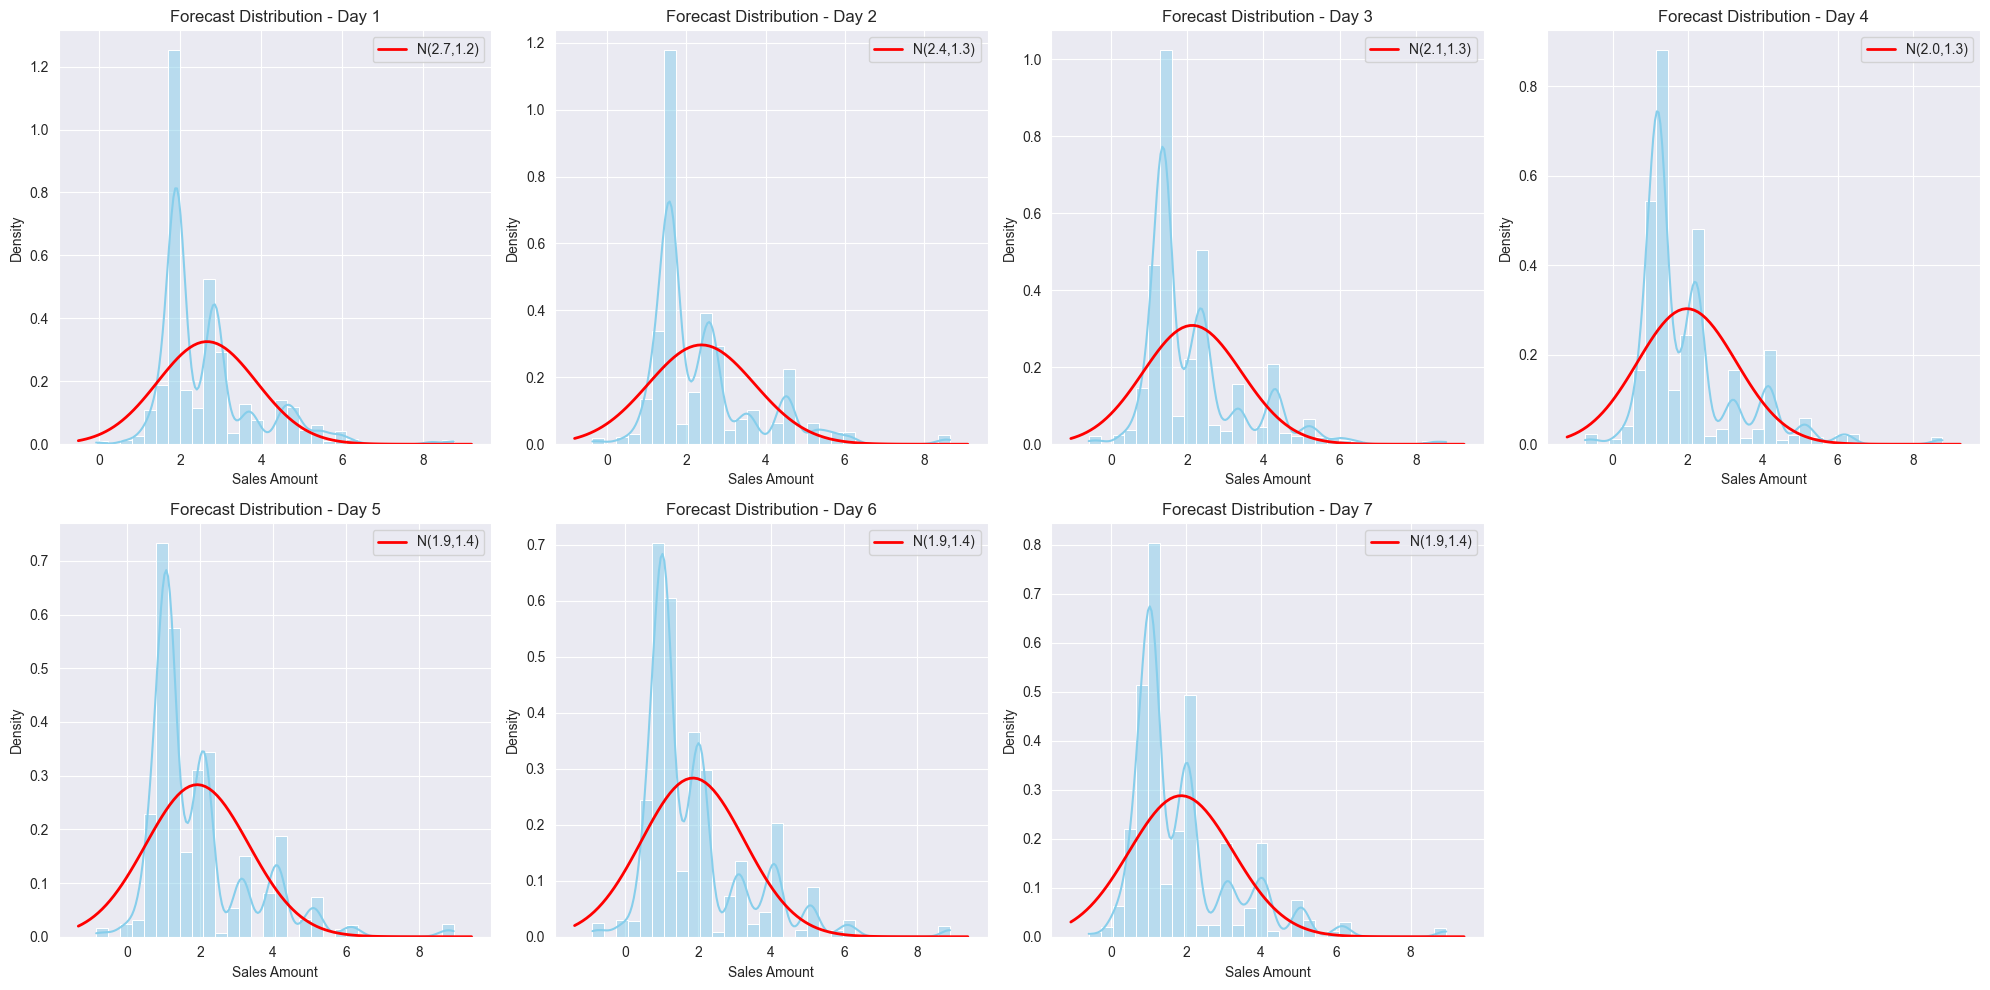

In [442]:
# -------------------------
# 8. Visualize the Bootstrapped Forecast Distributions
# -------------------------

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(7):
    samples = bootstrap_forecasts_df[i]
    ax = axes[i]
    sns.histplot(samples, kde=True, ax=ax, stat="density", bins=30, color='skyblue')
    ax.set_title(f"Forecast Distribution - Day {i+1}")
    ax.set_xlabel("Sales Amount")
    ax.set_ylabel("Density")

    mu, std = stats.norm.fit(samples)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2, label=f"N({mu:.1f},{std:.1f})")
    ax.legend()

if len(axes) > 7:
    axes[-1].axis('off')

plt.tight_layout()

save_dir = "Forecasts"
file_path = os.path.join(save_dir, f"Forecasts_{product}_{store}.png")

fig.savefig(file_path)
print(f"Saved forecast distribution plot as {file_path}")

plt.show()

In [443]:
def plot_histogram(data, index):
    mean = np.mean(data)
    std = np.std(data)

    bin_count = int(np.sqrt(len(data)))
    plt.subplot(1,2,1)
    sns.histplot(data=data, bins=bin_count, kde=False, color='blue')
    index += 1
    plt.title(f"Sales Histogram of Day-{index}")
    plt.xlabel("Sales Quantity")
    plt.ylabel("Frequency")

def plot_distribution(data, index):
    mean = np.mean(data)
    std = np.std(data)

    plt.subplot(1,2,2)
    sns.kdeplot(data=data, fill=True, color='red')
    index += 1
    plt.title(f"Sales Distribution of Day-{index}")
    plt.xlabel("Sales Quantity")

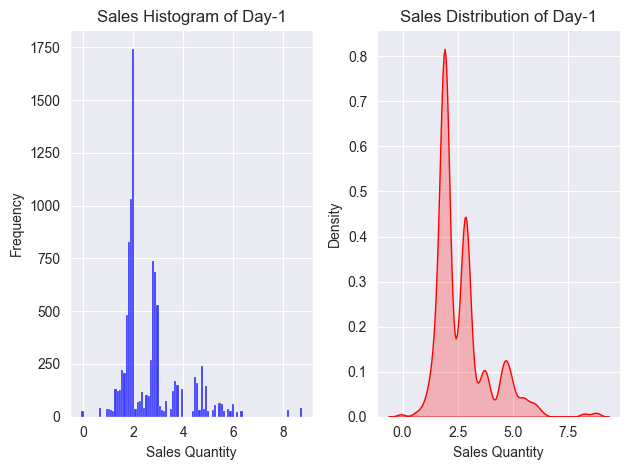

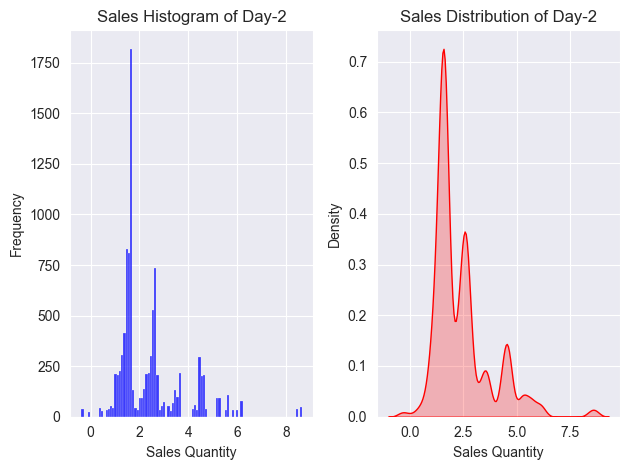

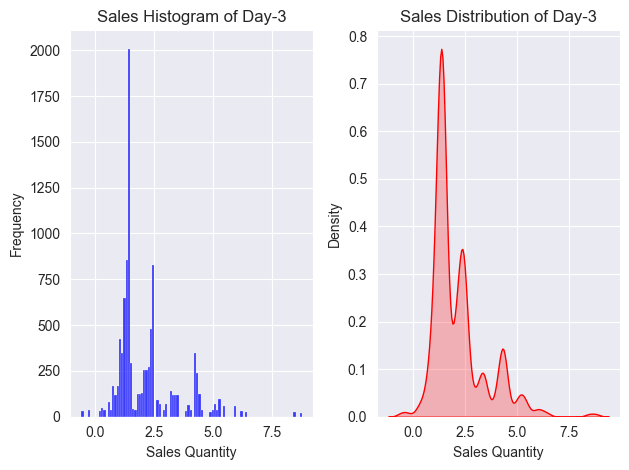

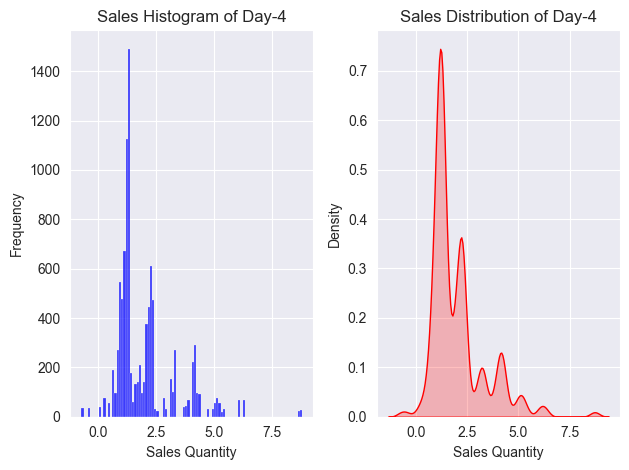

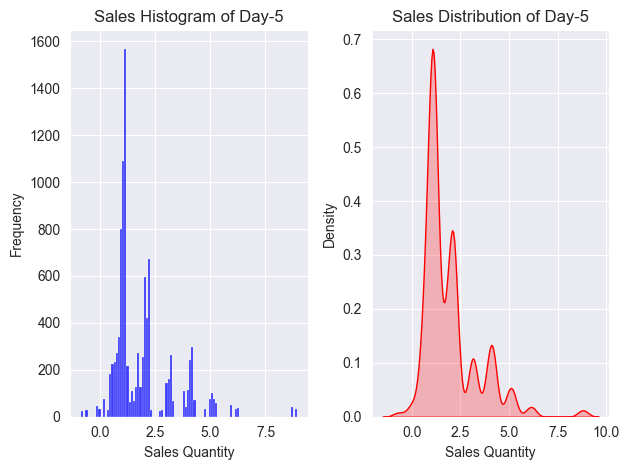

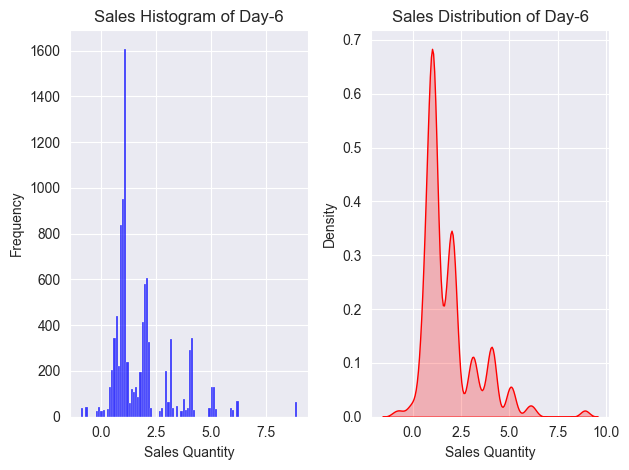

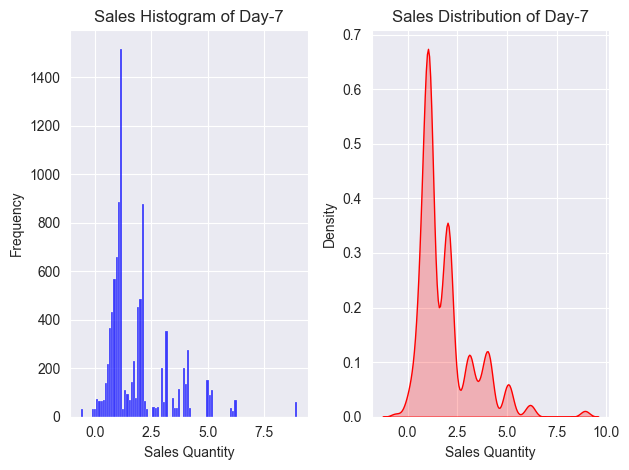

In [444]:
# Plot Histogram & Distribution

i = 0
for col in bootstrap_forecasts_df.columns:
    plot_histogram(bootstrap_forecasts_df[col], i)
    plot_distribution(bootstrap_forecasts_df[col], i)

    plt.tight_layout()
    plt.show()
    i += 1

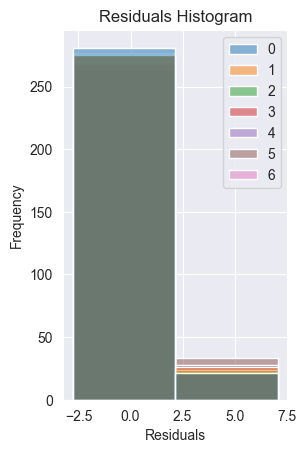

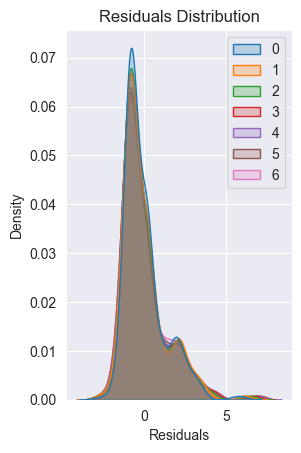

In [445]:
# -------------------------
# 9. Visualize the Residuals
# -------------------------

data = errors_list
bin_count = int(np.sqrt(len(data)))
plt.subplot(1,2,1)
sns.histplot(data=data, bins=bin_count, kde=False, color='blue')
plt.title(f"Residuals Histogram")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.show()

plt.subplot(1,2,2)
sns.kdeplot(data=data, fill=True, color='red')
plt.title(f"Residuals Distribution")
plt.xlabel("Residuals")

plt.show()